In [4]:
import sys
sys.path.append('..')

from diffusion_llms.models.llada import LladaBackbone
import torch
torch.mps.empty_cache()

device = 'mps'  # or 'cuda' for GPU, 'cpu' for CPU

# instantiate the LladaBackbone model
model = LladaBackbone()

IndentationError: expected an indented block after 'if' statement on line 38 (llada.py, line 40)

In [ ]:
model.transformer

NameError: name 'model' is not defined

In [ ]:
model.lm_head

NameError: name 'model' is not defined

# Plot logits of eos

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Base")

In [ ]:
import torch
prompt = "Hi, how are you?"
mask_id = 126336

# Fix: use input_ids (plural) instead of input_id
prompt = tokenizer(prompt, return_tensors="pt").input_ids

x = torch.full((1, 1024), mask_id, dtype=torch.long).to(
    model.device
)
x[:, : prompt.shape[1]] = prompt.clone()

prompt_index = x != mask_id

# Create a dummy target tensor - typically can be zeros or -100 for masked positions
dummy_target = torch.zeros_like(x)  # or torch.full_like(x, -100) 

# Pass both input and target to the model
logits = model(x).logits
logits = logits[:, :, tokenizer.eos_token_id].squeeze(0)  # (1024)
p = torch.nn.functional.softmax(logits.to(torch.float64), dim=-1)

AttributeError: 'tuple' object has no attribute 'device'

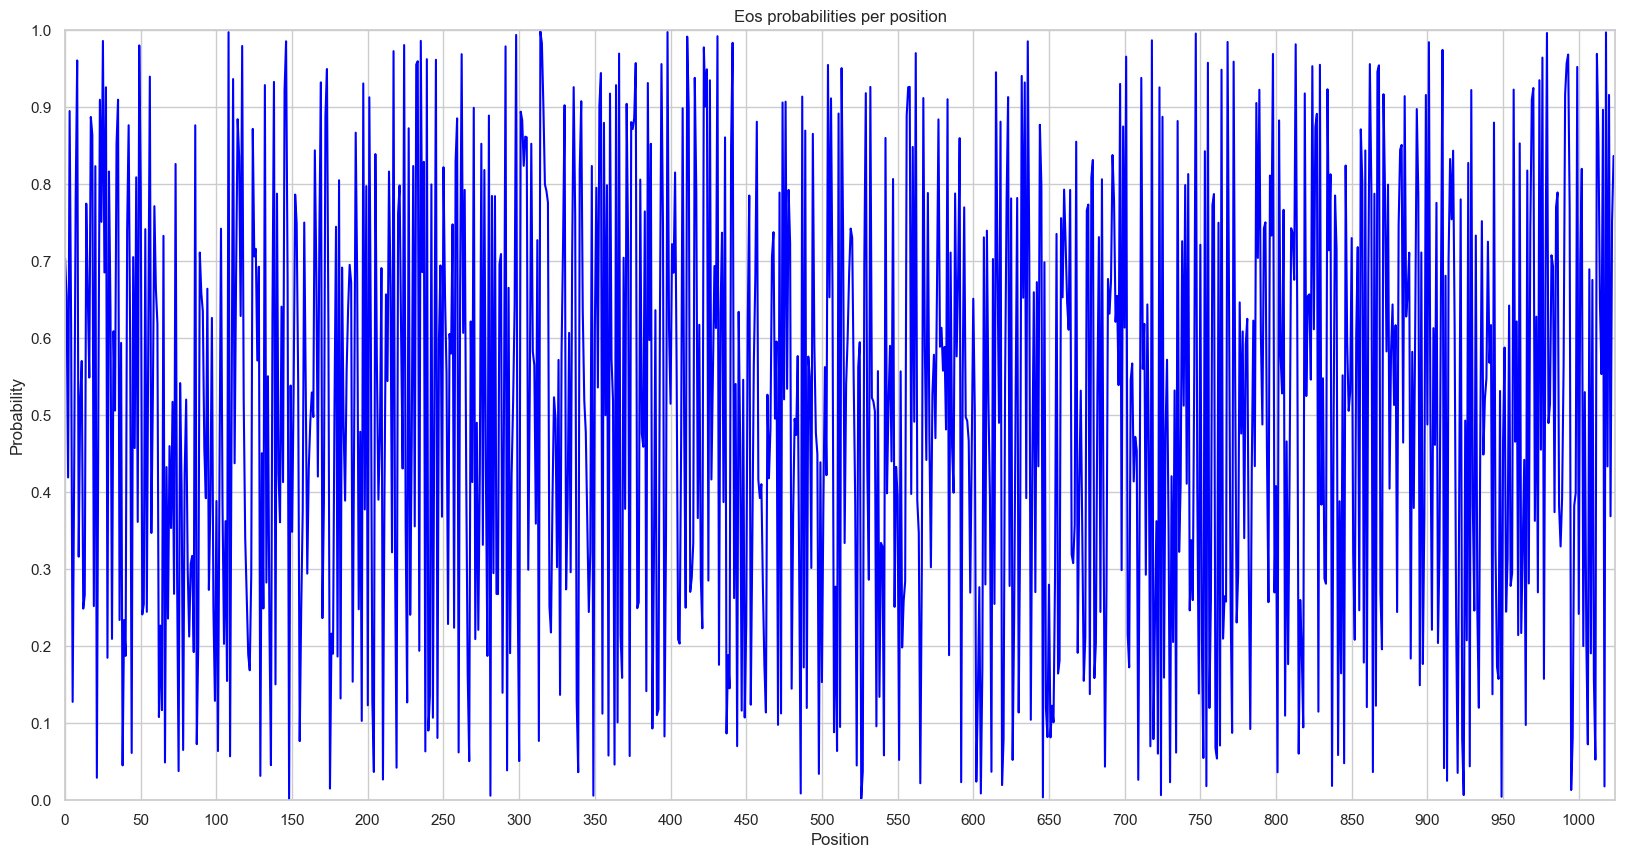

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
# plot the distribution of eos probabilities per position
p = p.cpu().numpy()
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.title("Eos probabilities per position")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.xticks(np.arange(0, 1024, step=50))
plt.yticks(np.arange(0, np.max(p) + np.std(p), step=0.1))
plt.xlim(0, 1024)
plt.ylim(0, 1)
plt.plot(p, color='blue', label='Eos probabilities')